<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning2020/blob/main/dcgan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writing a training loop from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/01<br>
**Last modified:** 2020/04/15<br>
**Description:** Complete guide to writing low-level training & evaluation loops.

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=en 

## Setup

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import matplotlib.pyplot as plt

## Introduction

Keras provides default training and evaluation loops, `fit()` and `evaluate()`.
Their usage is covered in the guide
[Training & evaluation with the built-in methods](/guides/training_with_built_in_methods/).

If you want to customize the learning algorithm of your model while still leveraging
the convenience of `fit()`
(for instance, to train a GAN using `fit()`), you can subclass the `Model` class and
implement your own `train_step()` method, which
is called repeatedly during `fit()`. This is covered in the guide
[Customizing what happens in `fit()`](/guides/customizing_what_happens_in_fit/).

Now, if you want very low-level control over training & evaluation, you should write
your own training & evaluation loops from scratch. This is what this guide is about.

## End-to-end example: a GAN training loop from scratch

You may be familiar with Generative Adversarial Networks (GANs). GANs can generate new
images that look almost real, by learning the latent distribution of a training
dataset of images (the "latent space" of the images).

A GAN is made of two parts: a "generator" model that maps points in the latent
space to points in image space, a "discriminator" model, a classifier
that can tell the difference between real images (from the training dataset)
and fake images (the output of the generator network).

A GAN training loop looks like this:

1) Train the discriminator.
- Sample a batch of random points in the latent space.
- Turn the points into fake images via the "generator" model.
- Get a batch of real images and combine them with the generated images.
- Train the "discriminator" model to classify generated vs. real images.

2) Train the generator.
- Sample random points in the latent space.
- Turn the points into fake images via the "generator" network.
- Get a batch of real images and combine them with the generated images.
- Train the "generator" model to "fool" the discriminator and classify the fake images
as real.

For a much more detailed overview of how GANs works, see
[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

Let's implement this training loop. First, create the discriminator meant to classify
fake vs real digits:

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

Then let's create a generator network,
that turns latent vectors into outputs of shape `(28, 28, 1)` (representing
MNIST digits):

In [8]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

## Speeding-up your training step with `tf.function`

The default runtime in TensorFlow 2.0 is
[eager execution](https://www.tensorflow.org/guide/eager). As such, our training loop
above executes eagerly.

This is great for debugging, but graph compilation has a definite performance
advantage. Describing your computation as a static graph enables the framework
to apply global performance optimizations. This is impossible when
the framework is constrained to greedly execute one operation after another,
with no knowledge of what comes next.

You can compile into a static graph any function that takes tensors as input.
Just add a `@tf.function` decorator on it, like this:

Here's the key bit: the training loop. As you can see it is quite straightforward. The
training step function only takes 17 lines.

In [9]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images


Let's train our GAN, by repeatedly calling `train_step` on batches of images.

Since our discriminator and generator are convnets, you're going to want to
run this code on a GPU.


Start epoch 0
Epoch =  0
discriminator loss at epoch 0: 0.40
adversarial loss at epoch 0: 2.07


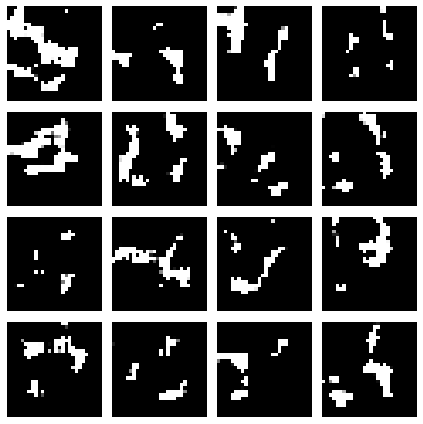


Start epoch 1
Epoch =  1
discriminator loss at epoch 1: 0.04
adversarial loss at epoch 1: 4.87


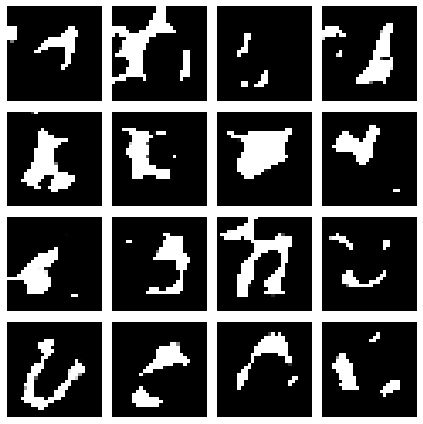


Start epoch 2
Epoch =  2
discriminator loss at epoch 2: -0.01
adversarial loss at epoch 2: 6.55


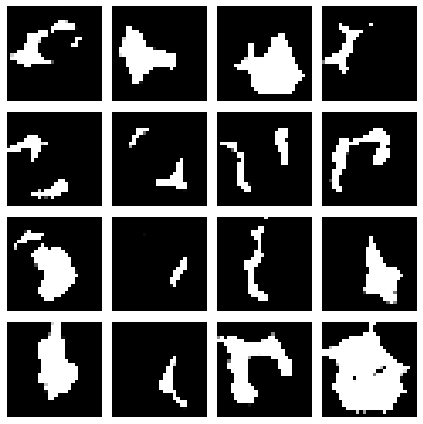


Start epoch 3
Epoch =  3
discriminator loss at epoch 3: 0.52
adversarial loss at epoch 3: 1.89


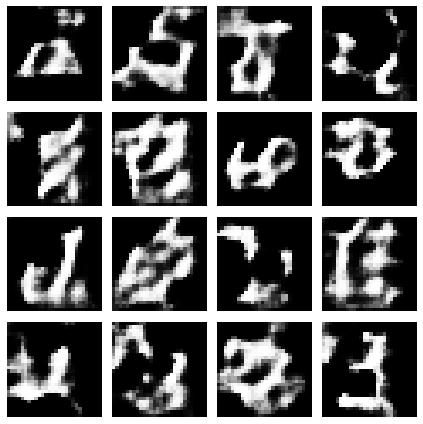


Start epoch 4
Epoch =  4
discriminator loss at epoch 4: 0.52
adversarial loss at epoch 4: 1.34


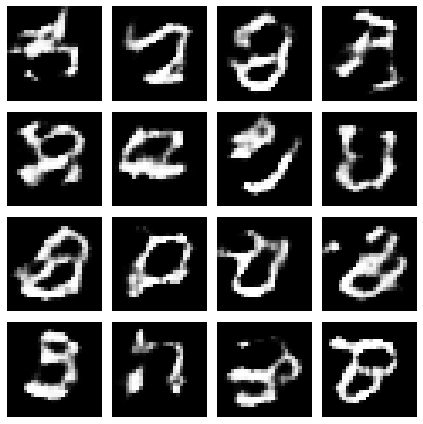


Start epoch 5
Epoch =  5
discriminator loss at epoch 5: 0.51
adversarial loss at epoch 5: 1.38


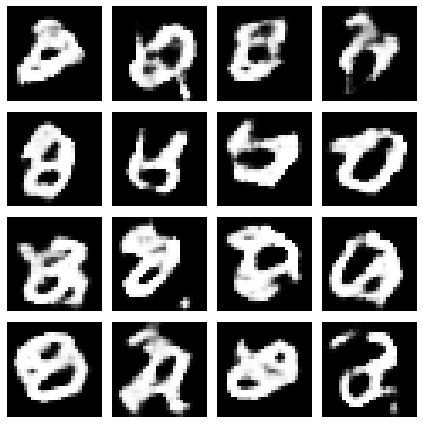


Start epoch 6
Epoch =  6
discriminator loss at epoch 6: 0.53
adversarial loss at epoch 6: 1.39


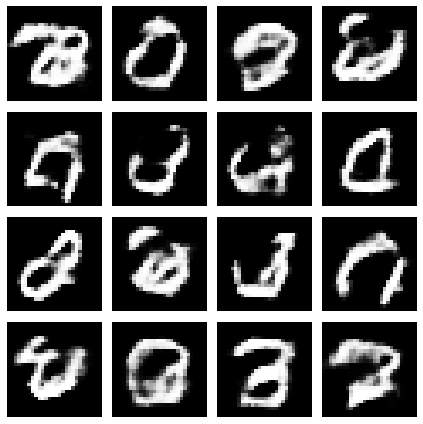


Start epoch 7
Epoch =  7
discriminator loss at epoch 7: 0.51
adversarial loss at epoch 7: 1.25


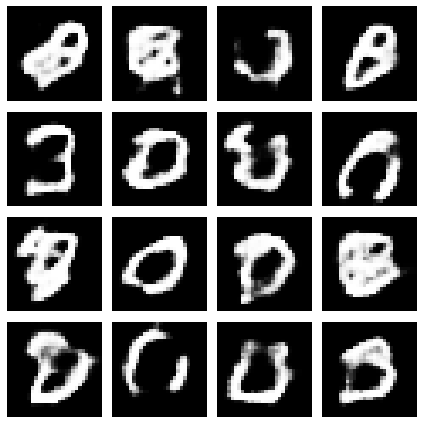


Start epoch 8
Epoch =  8
discriminator loss at epoch 8: 0.58
adversarial loss at epoch 8: 1.15


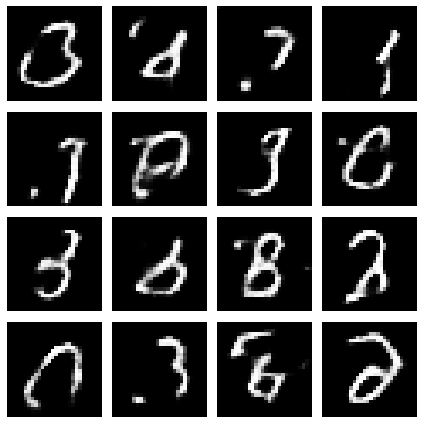


Start epoch 9
Epoch =  9
discriminator loss at epoch 9: 0.61
adversarial loss at epoch 9: 1.05


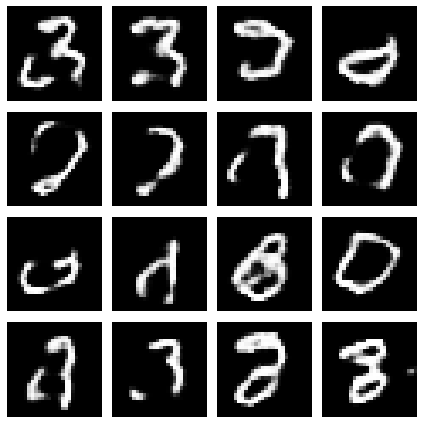


Start epoch 10
Epoch =  10
discriminator loss at epoch 10: 0.61
adversarial loss at epoch 10: 1.01


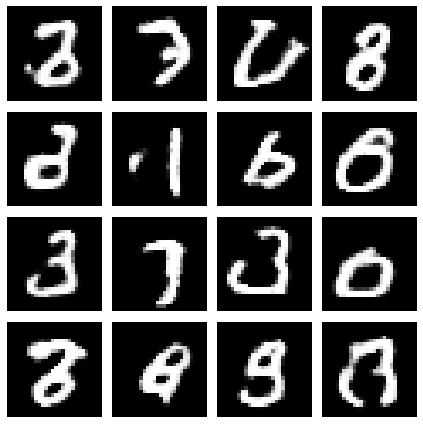


Start epoch 11
Epoch =  11
discriminator loss at epoch 11: 0.69
adversarial loss at epoch 11: 0.92


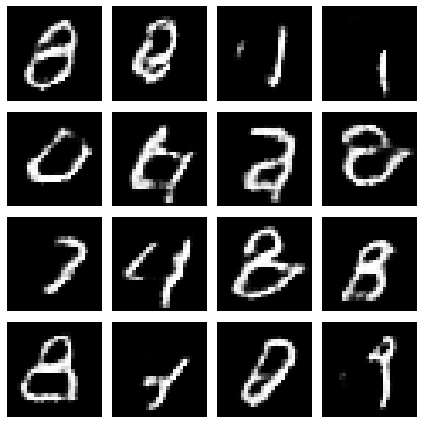


Start epoch 12
Epoch =  12
discriminator loss at epoch 12: 0.64
adversarial loss at epoch 12: 1.06


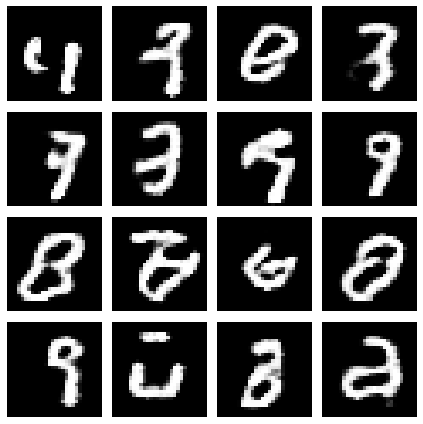


Start epoch 13
Epoch =  13
discriminator loss at epoch 13: 0.56
adversarial loss at epoch 13: 0.95


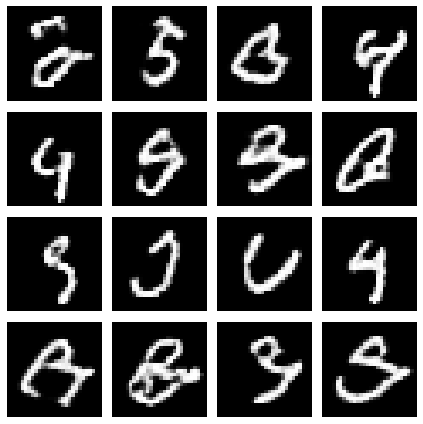


Start epoch 14
Epoch =  14
discriminator loss at epoch 14: 0.53
adversarial loss at epoch 14: 1.28


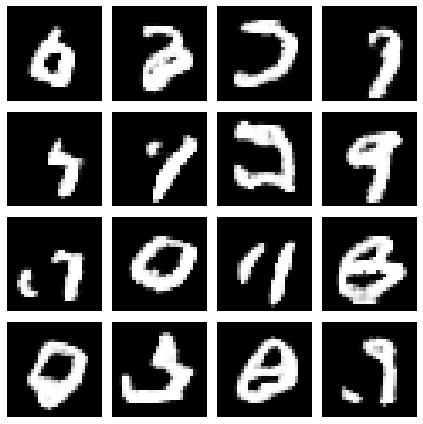


Start epoch 15
Epoch =  15
discriminator loss at epoch 15: 0.49
adversarial loss at epoch 15: 1.17


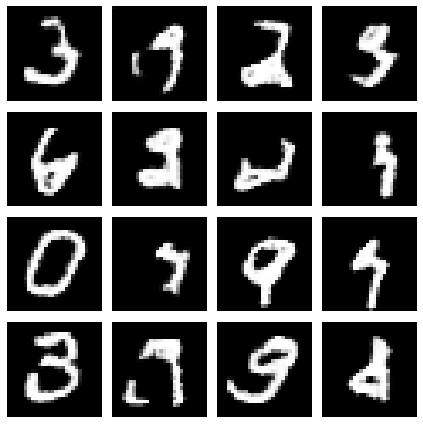


Start epoch 16
Epoch =  16
discriminator loss at epoch 16: 0.56
adversarial loss at epoch 16: 1.18


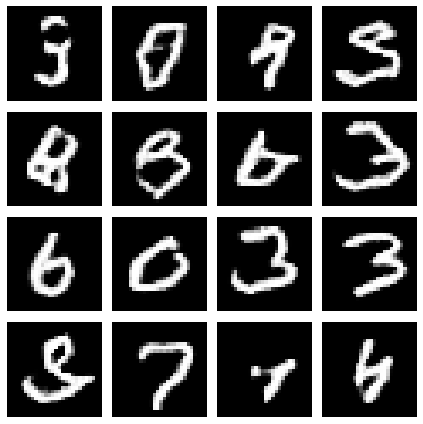


Start epoch 17
Epoch =  17
discriminator loss at epoch 17: 0.56
adversarial loss at epoch 17: 1.31


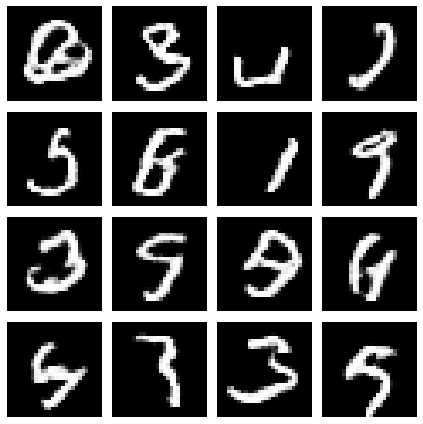


Start epoch 18
Epoch =  18
discriminator loss at epoch 18: 0.57
adversarial loss at epoch 18: 1.16


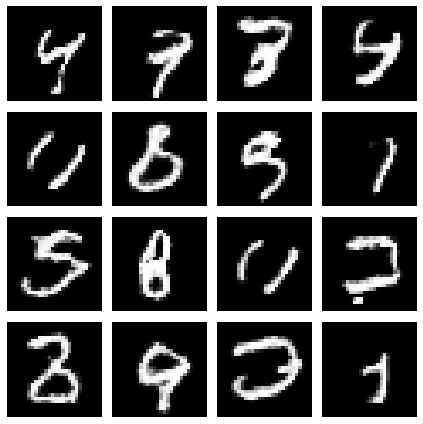


Start epoch 19
Epoch =  19
discriminator loss at epoch 19: 0.64
adversarial loss at epoch 19: 1.25


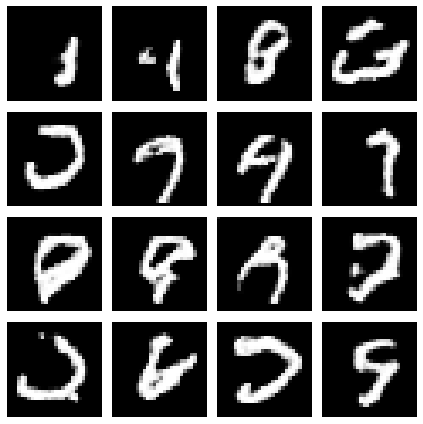


Start epoch 20
Epoch =  20
discriminator loss at epoch 20: 0.62
adversarial loss at epoch 20: 1.13


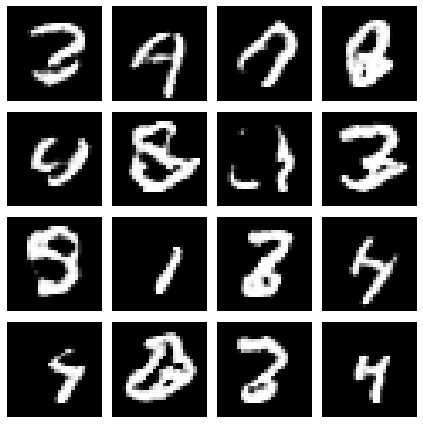


Start epoch 21
Epoch =  21
discriminator loss at epoch 21: 0.66
adversarial loss at epoch 21: 1.03


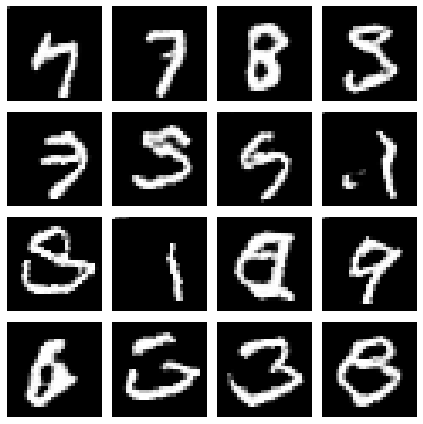


Start epoch 22
Epoch =  22
discriminator loss at epoch 22: 0.61
adversarial loss at epoch 22: 0.79


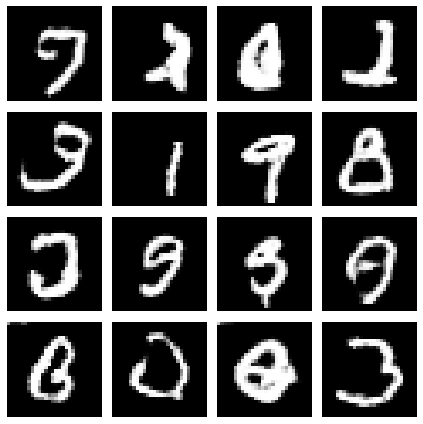


Start epoch 23
Epoch =  23
discriminator loss at epoch 23: 0.57
adversarial loss at epoch 23: 0.94


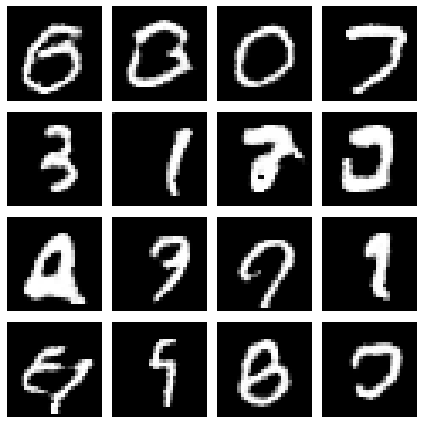


Start epoch 24
Epoch =  24
discriminator loss at epoch 24: 0.68
adversarial loss at epoch 24: 0.90


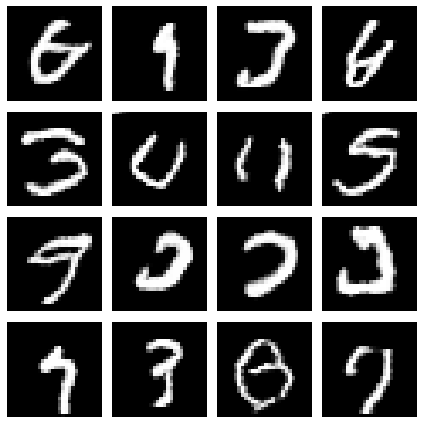


Start epoch 25
Epoch =  25
discriminator loss at epoch 25: 0.65
adversarial loss at epoch 25: 0.97


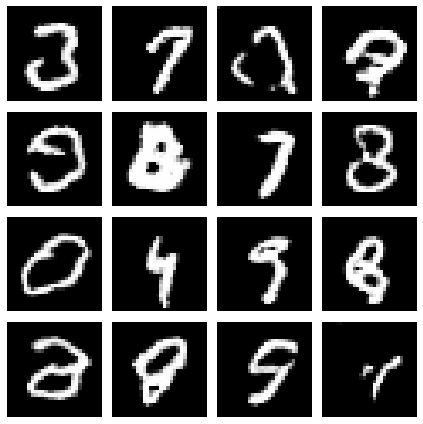


Start epoch 26
Epoch =  26
discriminator loss at epoch 26: 0.65
adversarial loss at epoch 26: 1.04


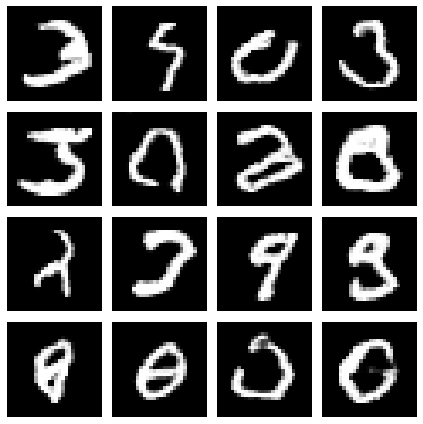


Start epoch 27
Epoch =  27
discriminator loss at epoch 27: 0.65
adversarial loss at epoch 27: 1.09


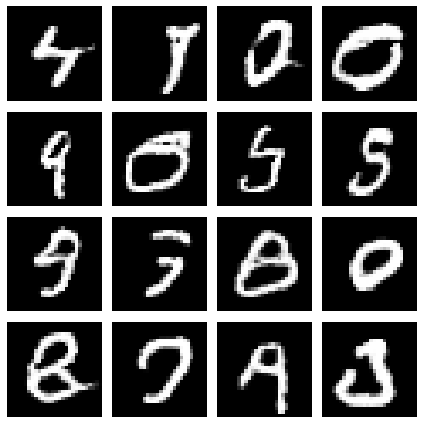


Start epoch 28
Epoch =  28
discriminator loss at epoch 28: 0.64
adversarial loss at epoch 28: 0.94


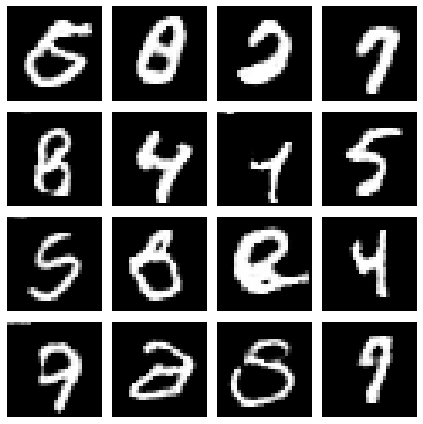


Start epoch 29
Epoch =  29
discriminator loss at epoch 29: 0.62
adversarial loss at epoch 29: 1.06


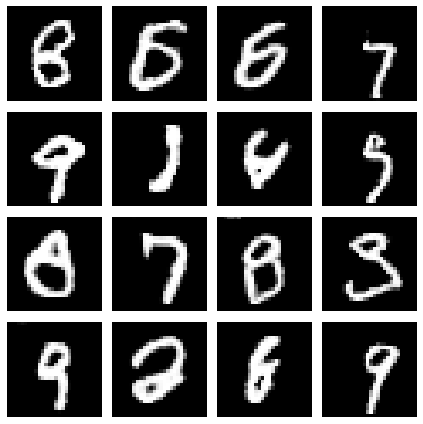


Start epoch 30
Epoch =  30
discriminator loss at epoch 30: 0.61
adversarial loss at epoch 30: 0.99


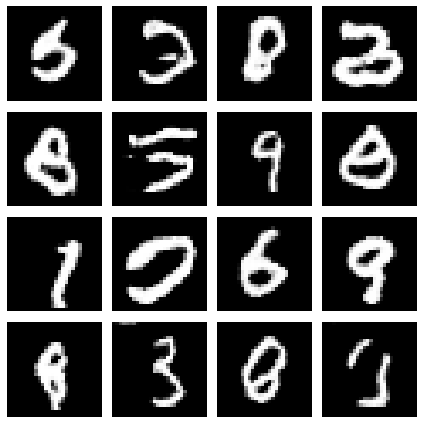


Start epoch 31
Epoch =  31
discriminator loss at epoch 31: 0.63
adversarial loss at epoch 31: 1.03


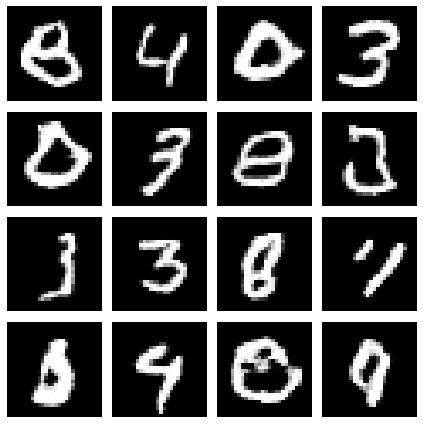


Start epoch 32
Epoch =  32
discriminator loss at epoch 32: 0.62
adversarial loss at epoch 32: 0.99


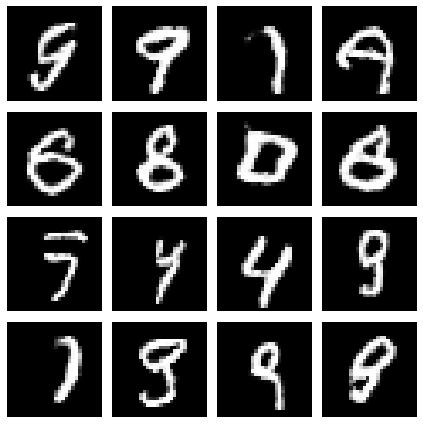


Start epoch 33
Epoch =  33
discriminator loss at epoch 33: 0.59
adversarial loss at epoch 33: 1.06


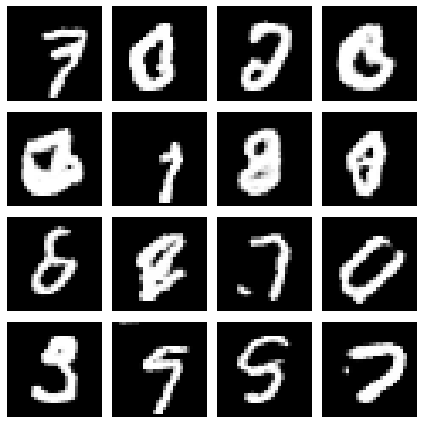


Start epoch 34
Epoch =  34
discriminator loss at epoch 34: 0.59
adversarial loss at epoch 34: 1.05


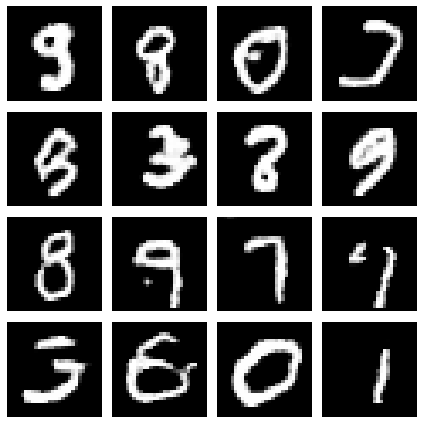


Start epoch 35
Epoch =  35
discriminator loss at epoch 35: 0.65
adversarial loss at epoch 35: 0.98


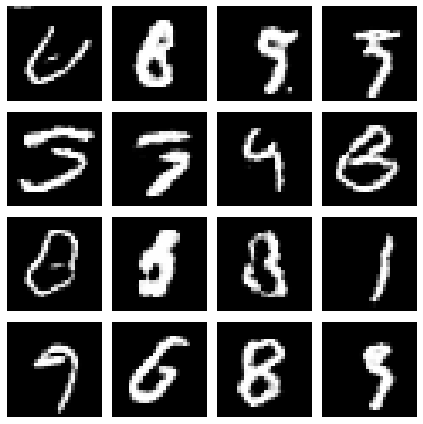


Start epoch 36
Epoch =  36
discriminator loss at epoch 36: 0.57
adversarial loss at epoch 36: 1.04


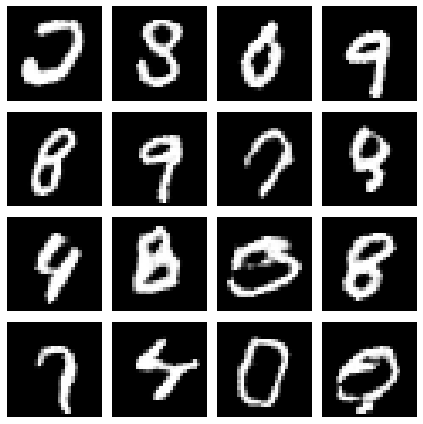


Start epoch 37
Epoch =  37
discriminator loss at epoch 37: 0.59
adversarial loss at epoch 37: 1.11


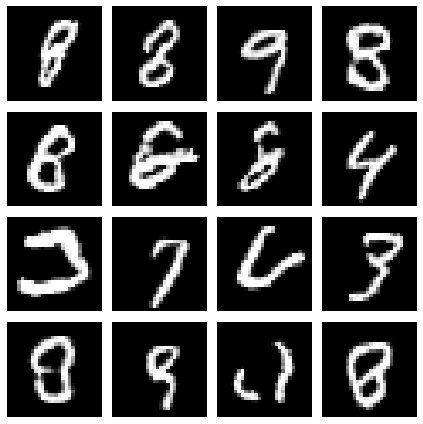


Start epoch 38
Epoch =  38
discriminator loss at epoch 38: 0.63
adversarial loss at epoch 38: 1.15


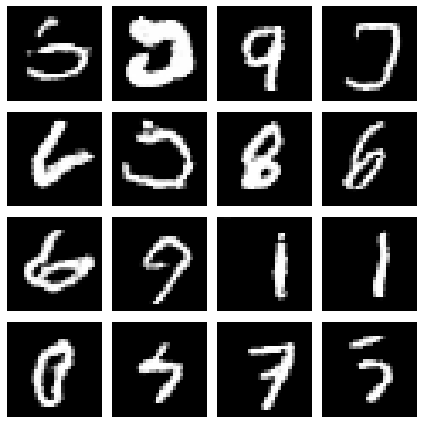


Start epoch 39
Epoch =  39
discriminator loss at epoch 39: 0.61
adversarial loss at epoch 39: 1.08


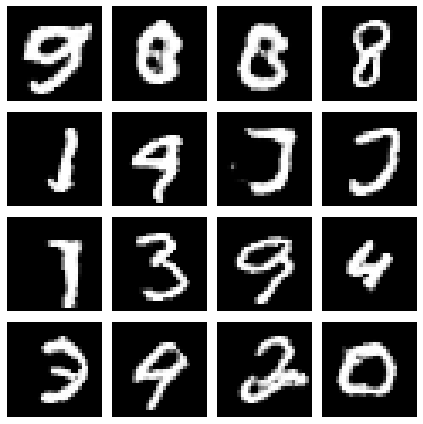


Start epoch 40
Epoch =  40
discriminator loss at epoch 40: 0.62
adversarial loss at epoch 40: 0.87


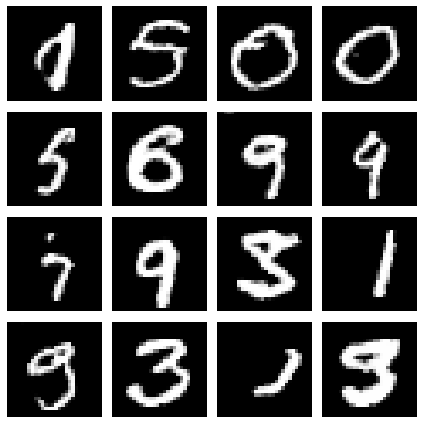


Start epoch 41
Epoch =  41
discriminator loss at epoch 41: 0.60
adversarial loss at epoch 41: 0.97


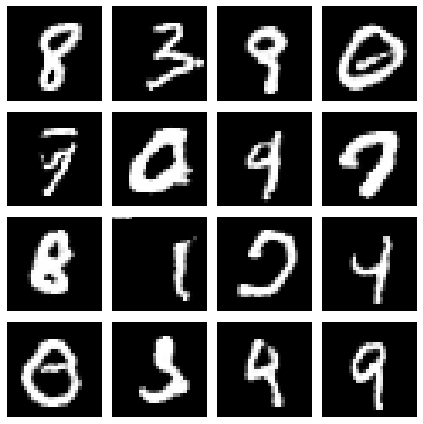


Start epoch 42
Epoch =  42
discriminator loss at epoch 42: 0.61
adversarial loss at epoch 42: 1.03


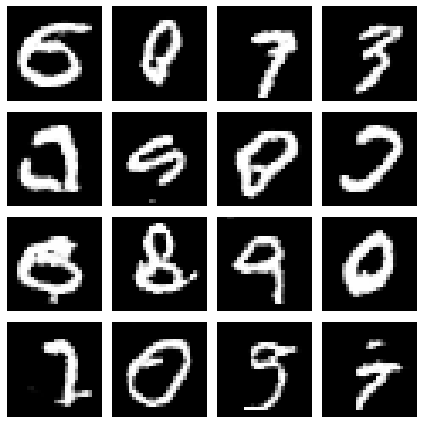


Start epoch 43
Epoch =  43
discriminator loss at epoch 43: 0.62
adversarial loss at epoch 43: 1.05


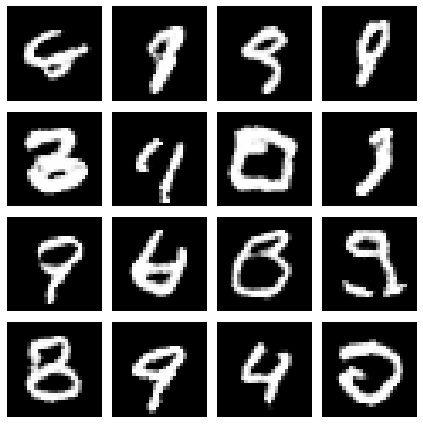


Start epoch 44
Epoch =  44
discriminator loss at epoch 44: 0.59
adversarial loss at epoch 44: 1.23


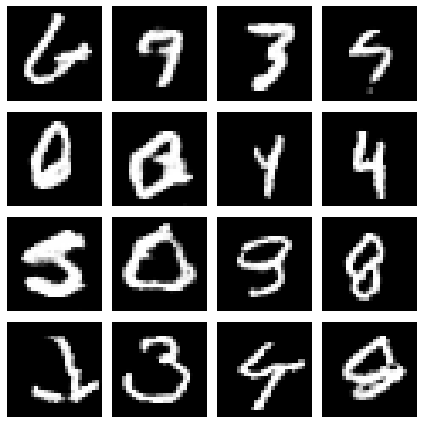


Start epoch 45
Epoch =  45
discriminator loss at epoch 45: 0.64
adversarial loss at epoch 45: 1.04


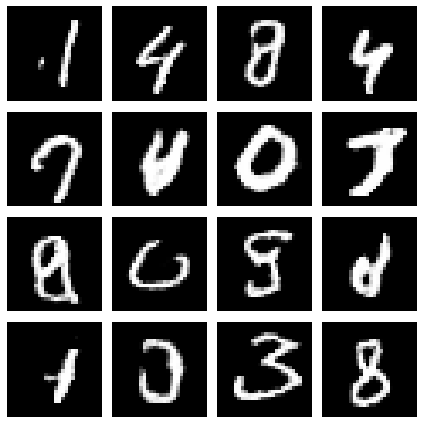


Start epoch 46
Epoch =  46
discriminator loss at epoch 46: 0.65
adversarial loss at epoch 46: 0.87


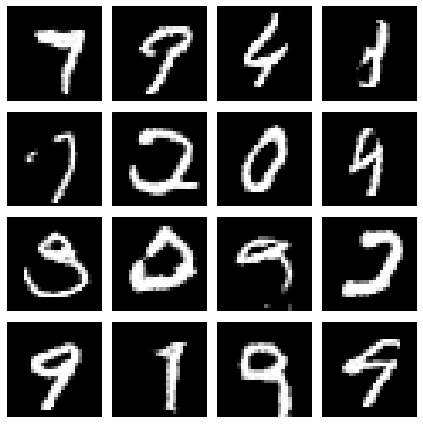


Start epoch 47
Epoch =  47
discriminator loss at epoch 47: 0.64
adversarial loss at epoch 47: 1.18


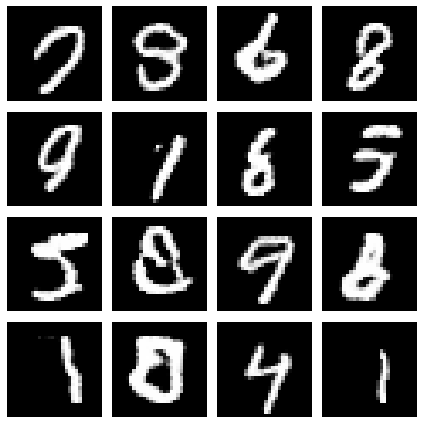


Start epoch 48
Epoch =  48
discriminator loss at epoch 48: 0.60
adversarial loss at epoch 48: 1.05


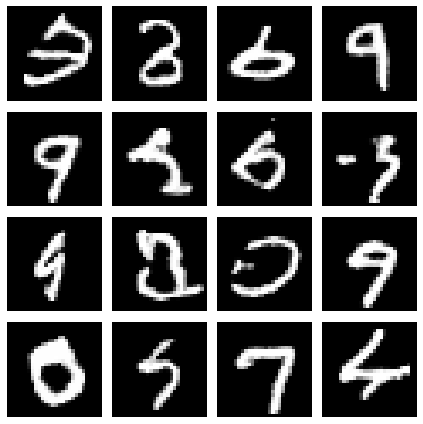


Start epoch 49
Epoch =  49
discriminator loss at epoch 49: 0.62
adversarial loss at epoch 49: 0.84


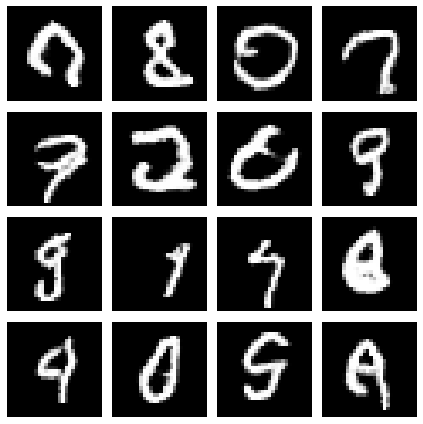


Start epoch 50
Epoch =  50
discriminator loss at epoch 50: 0.62
adversarial loss at epoch 50: 1.15


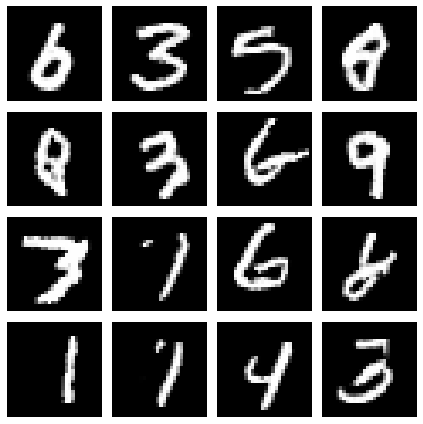


Start epoch 51
Epoch =  51
discriminator loss at epoch 51: 0.61
adversarial loss at epoch 51: 1.15


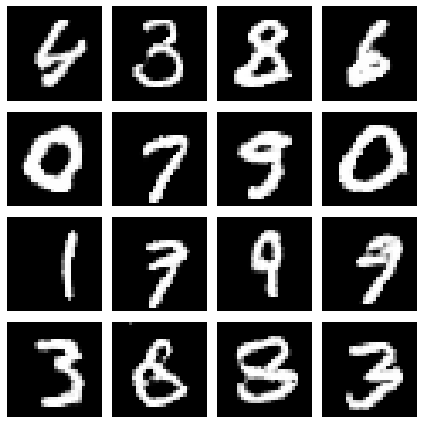


Start epoch 52
Epoch =  52
discriminator loss at epoch 52: 0.66
adversarial loss at epoch 52: 0.97


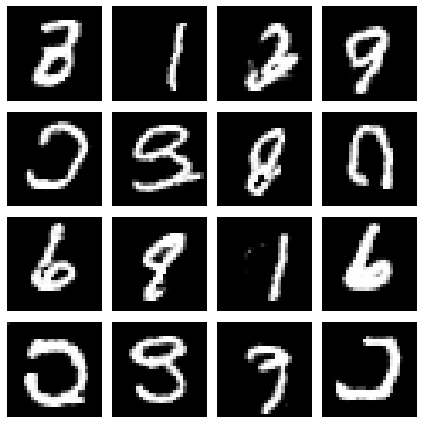


Start epoch 53
Epoch =  53
discriminator loss at epoch 53: 0.63
adversarial loss at epoch 53: 0.99


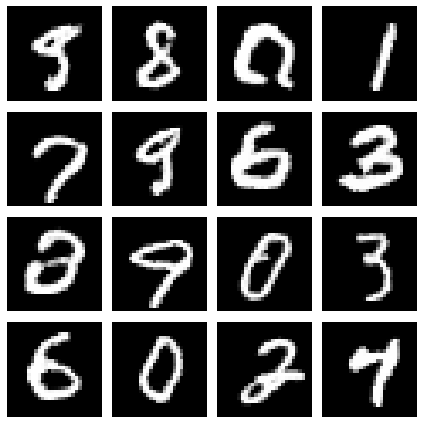


Start epoch 54
Epoch =  54
discriminator loss at epoch 54: 0.60
adversarial loss at epoch 54: 1.04


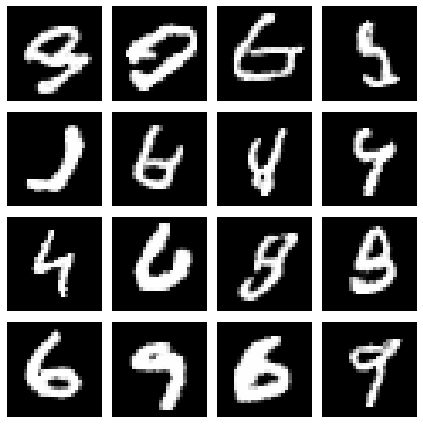


Start epoch 55
Epoch =  55
discriminator loss at epoch 55: 0.68
adversarial loss at epoch 55: 1.03


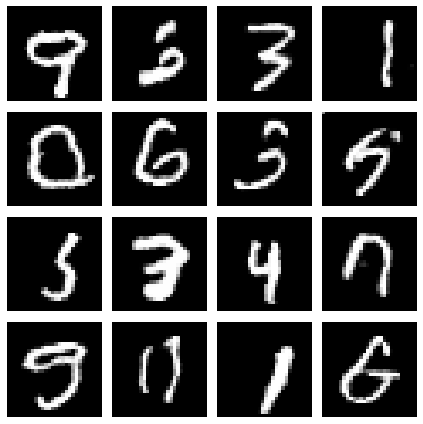


Start epoch 56
Epoch =  56
discriminator loss at epoch 56: 0.64
adversarial loss at epoch 56: 1.16


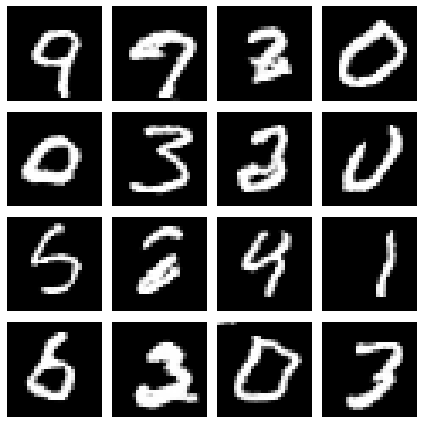


Start epoch 57
Epoch =  57
discriminator loss at epoch 57: 0.62
adversarial loss at epoch 57: 1.02


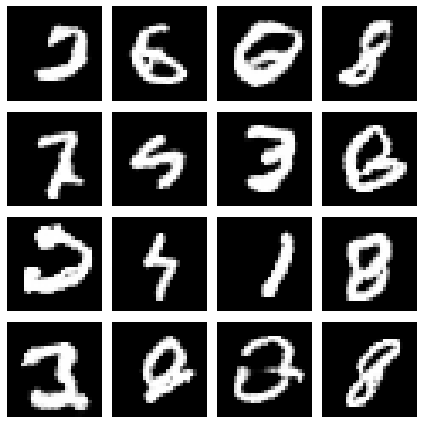


Start epoch 58
Epoch =  58
discriminator loss at epoch 58: 0.61
adversarial loss at epoch 58: 1.13


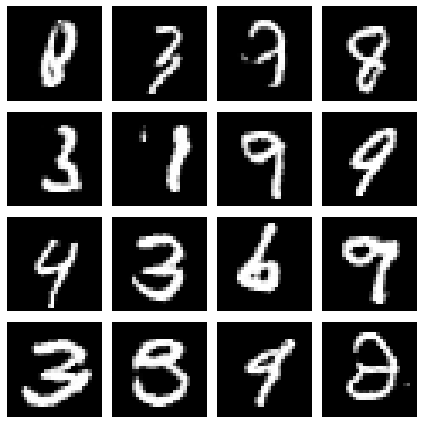


Start epoch 59
Epoch =  59
discriminator loss at epoch 59: 0.62
adversarial loss at epoch 59: 1.22


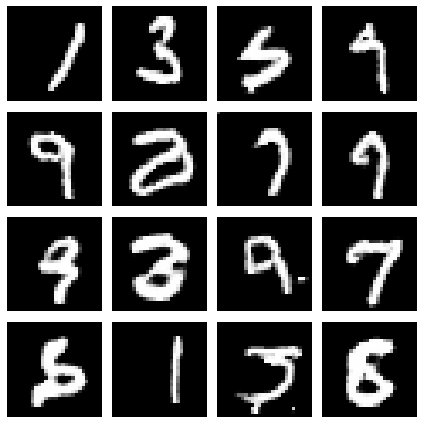


Start epoch 60
Epoch =  60
discriminator loss at epoch 60: 0.64
adversarial loss at epoch 60: 1.03


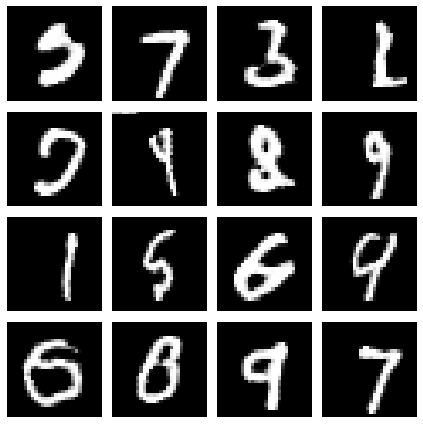


Start epoch 61
Epoch =  61
discriminator loss at epoch 61: 0.61
adversarial loss at epoch 61: 1.06


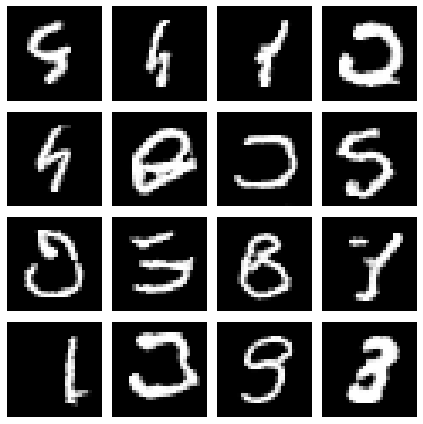


Start epoch 62
Epoch =  62
discriminator loss at epoch 62: 0.62
adversarial loss at epoch 62: 0.95


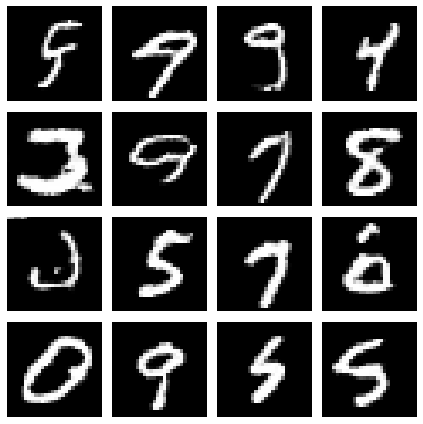


Start epoch 63
Epoch =  63
discriminator loss at epoch 63: 0.62
adversarial loss at epoch 63: 1.00


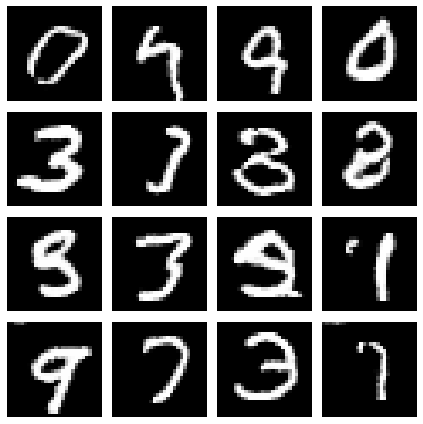


Start epoch 64
Epoch =  64
discriminator loss at epoch 64: 0.63
adversarial loss at epoch 64: 1.13


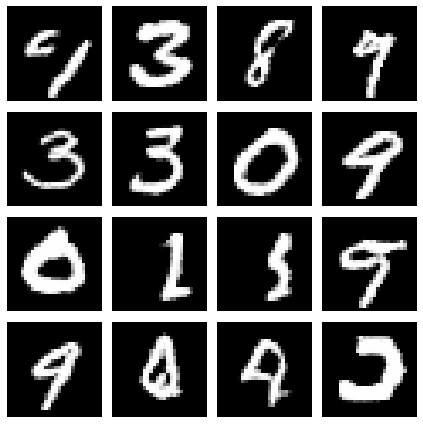


Start epoch 65
Epoch =  65
discriminator loss at epoch 65: 0.66
adversarial loss at epoch 65: 1.01


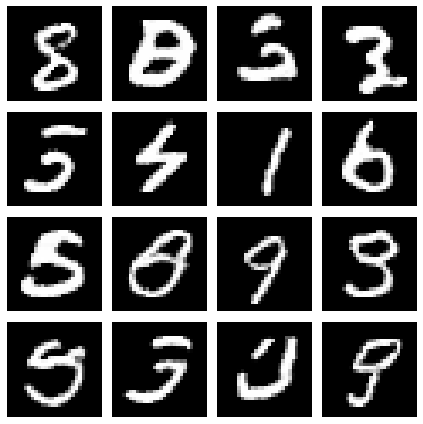


Start epoch 66
Epoch =  66
discriminator loss at epoch 66: 0.65
adversarial loss at epoch 66: 1.03


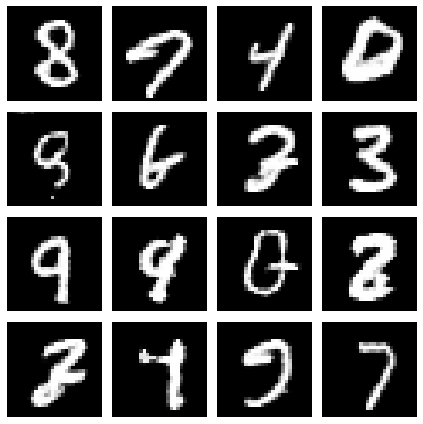


Start epoch 67
Epoch =  67
discriminator loss at epoch 67: 0.66
adversarial loss at epoch 67: 1.00


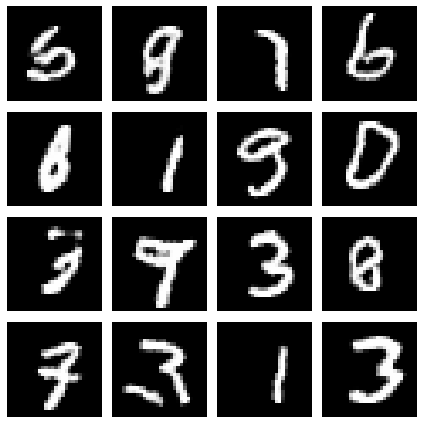


Start epoch 68
Epoch =  68
discriminator loss at epoch 68: 0.61
adversarial loss at epoch 68: 1.13


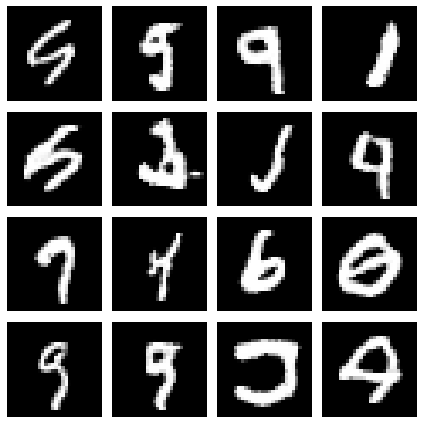


Start epoch 69
Epoch =  69
discriminator loss at epoch 69: 0.66
adversarial loss at epoch 69: 0.93


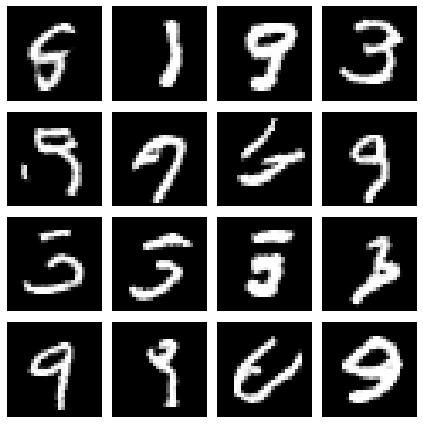


Start epoch 70
Epoch =  70
discriminator loss at epoch 70: 0.66
adversarial loss at epoch 70: 1.03


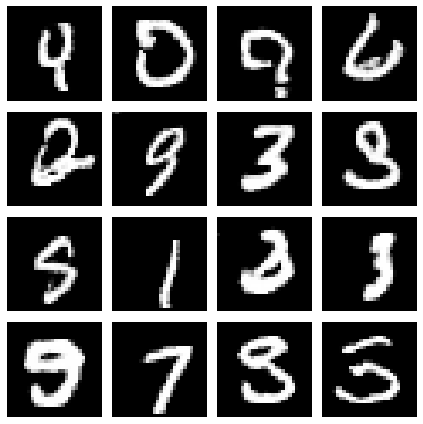


Start epoch 71
Epoch =  71
discriminator loss at epoch 71: 0.66
adversarial loss at epoch 71: 1.00


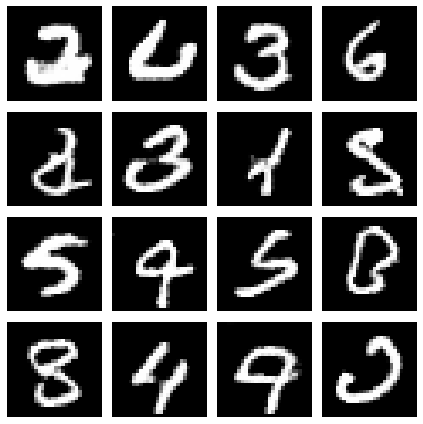


Start epoch 72
Epoch =  72
discriminator loss at epoch 72: 0.62
adversarial loss at epoch 72: 0.99


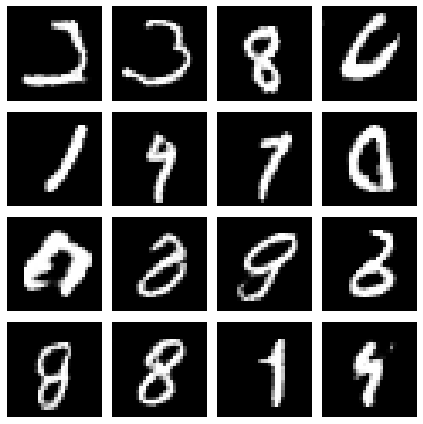


Start epoch 73
Epoch =  73
discriminator loss at epoch 73: 0.63
adversarial loss at epoch 73: 0.74


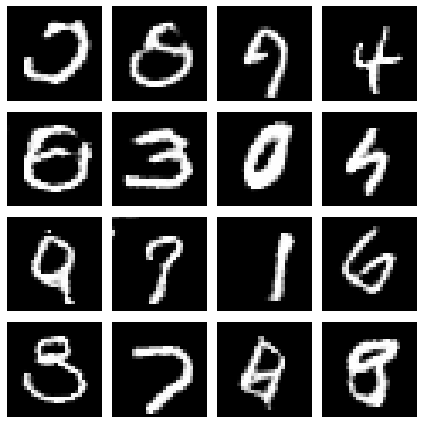


Start epoch 74
Epoch =  74
discriminator loss at epoch 74: 0.61
adversarial loss at epoch 74: 1.00


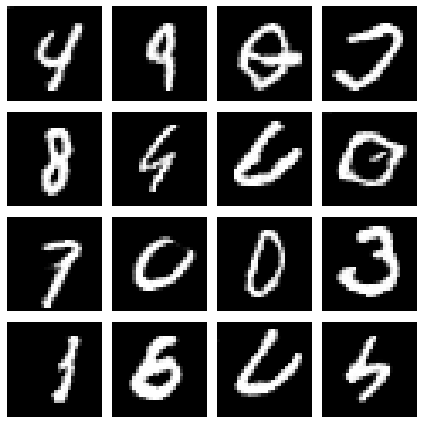


Start epoch 75
Epoch =  75
discriminator loss at epoch 75: 0.63
adversarial loss at epoch 75: 0.99


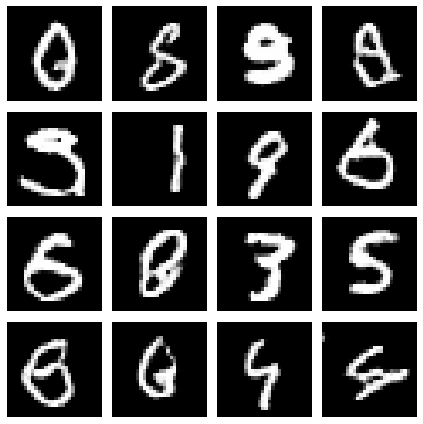


Start epoch 76
Epoch =  76
discriminator loss at epoch 76: 0.62
adversarial loss at epoch 76: 0.97


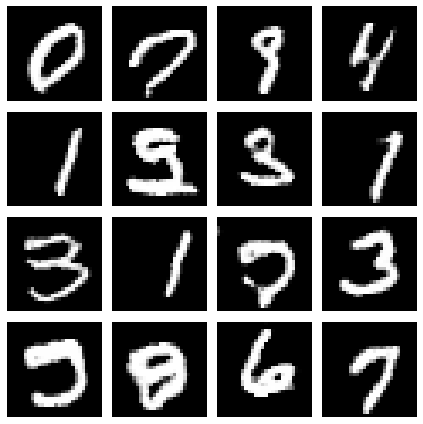


Start epoch 77
Epoch =  77
discriminator loss at epoch 77: 0.66
adversarial loss at epoch 77: 0.93


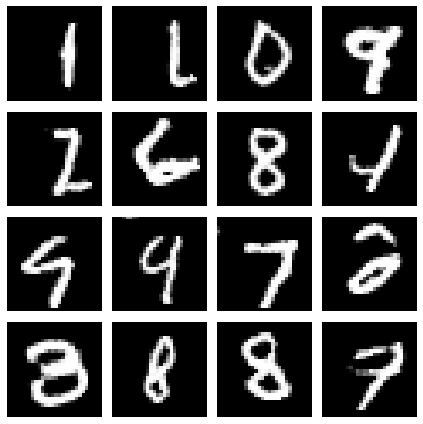


Start epoch 78
Epoch =  78
discriminator loss at epoch 78: 0.66
adversarial loss at epoch 78: 1.06


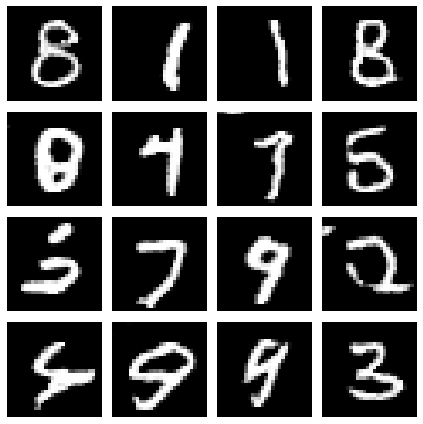


Start epoch 79
Epoch =  79
discriminator loss at epoch 79: 0.60
adversarial loss at epoch 79: 0.96


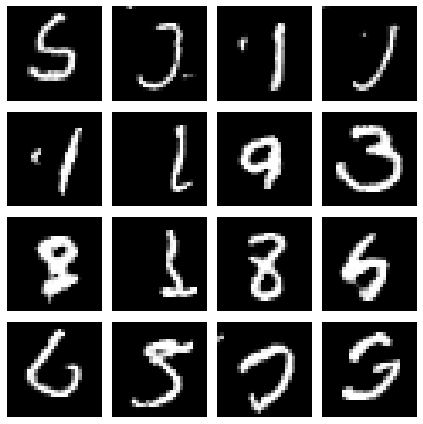


Start epoch 80
Epoch =  80
discriminator loss at epoch 80: 0.66
adversarial loss at epoch 80: 0.93


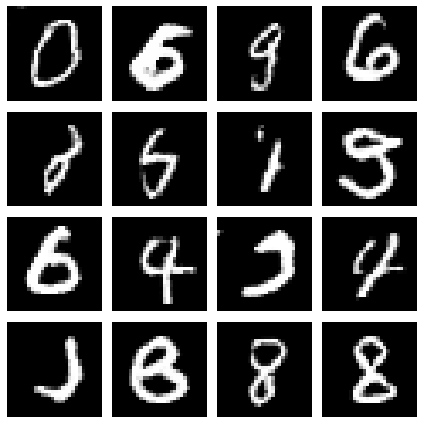


Start epoch 81
Epoch =  81
discriminator loss at epoch 81: 0.59
adversarial loss at epoch 81: 1.11


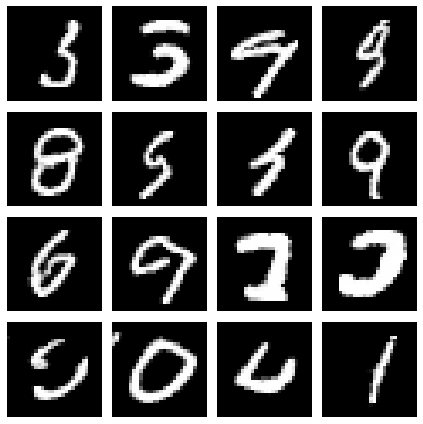


Start epoch 82
Epoch =  82
discriminator loss at epoch 82: 0.62
adversarial loss at epoch 82: 1.08


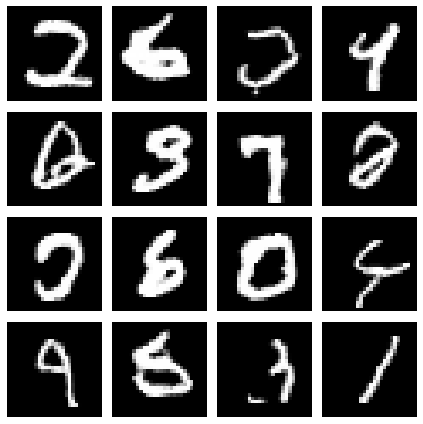


Start epoch 83
Epoch =  83
discriminator loss at epoch 83: 0.64
adversarial loss at epoch 83: 0.99


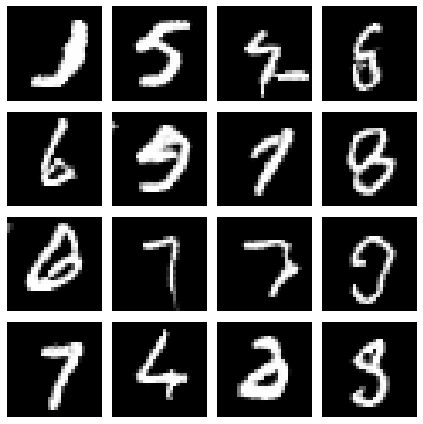


Start epoch 84
Epoch =  84
discriminator loss at epoch 84: 0.67
adversarial loss at epoch 84: 1.00


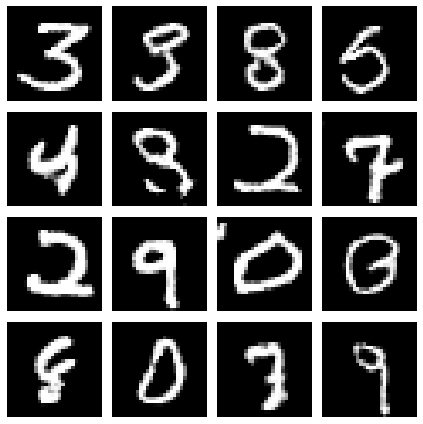


Start epoch 85
Epoch =  85
discriminator loss at epoch 85: 0.63
adversarial loss at epoch 85: 1.04


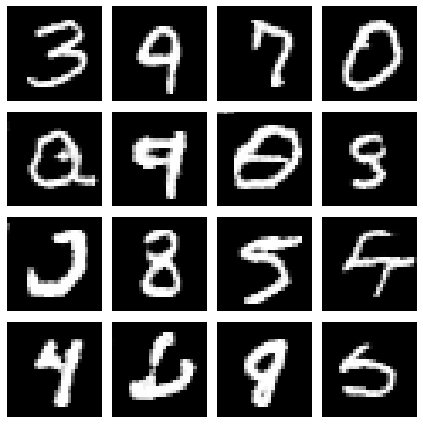


Start epoch 86
Epoch =  86
discriminator loss at epoch 86: 0.62
adversarial loss at epoch 86: 1.06


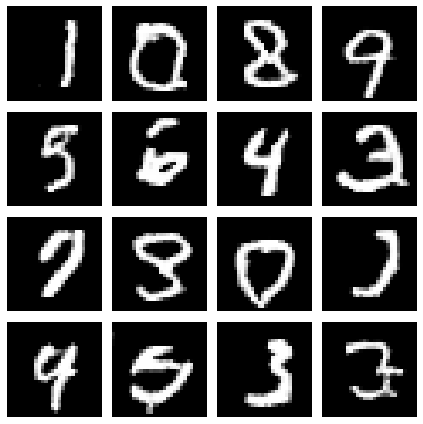


Start epoch 87
Epoch =  87
discriminator loss at epoch 87: 0.66
adversarial loss at epoch 87: 1.03


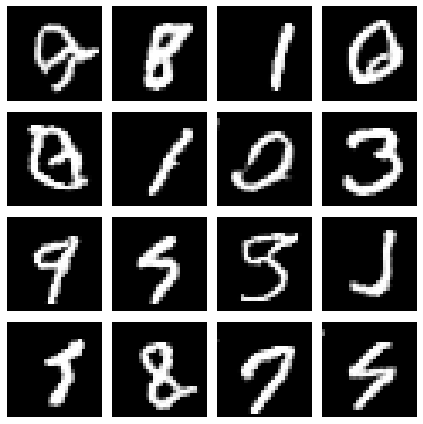


Start epoch 88
Epoch =  88
discriminator loss at epoch 88: 0.61
adversarial loss at epoch 88: 1.09


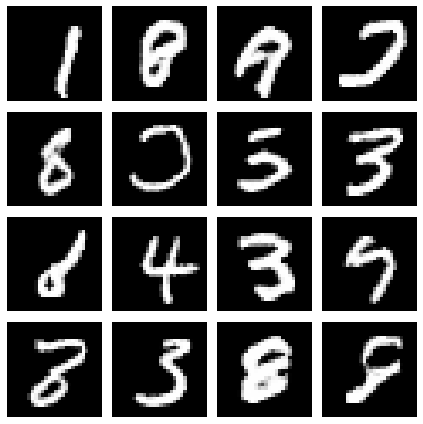


Start epoch 89
Epoch =  89
discriminator loss at epoch 89: 0.63
adversarial loss at epoch 89: 1.04


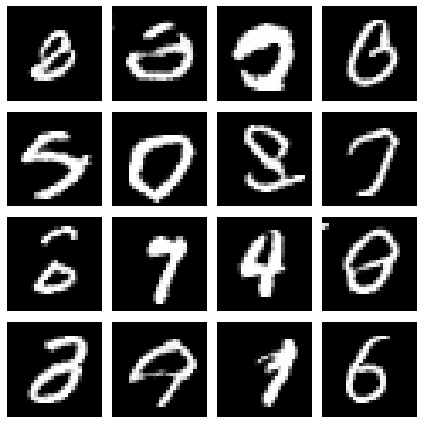


Start epoch 90
Epoch =  90
discriminator loss at epoch 90: 0.67
adversarial loss at epoch 90: 1.12


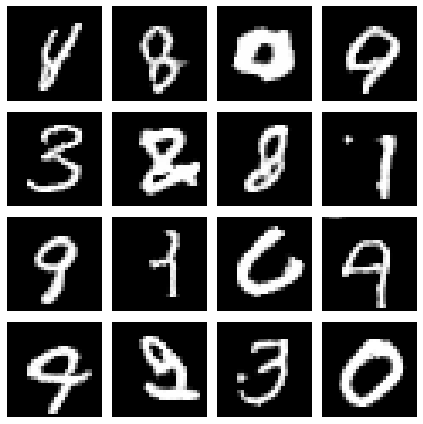


Start epoch 91
Epoch =  91
discriminator loss at epoch 91: 0.63
adversarial loss at epoch 91: 0.87


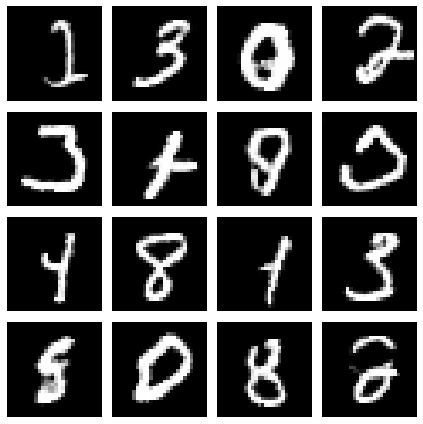


Start epoch 92
Epoch =  92
discriminator loss at epoch 92: 0.61
adversarial loss at epoch 92: 1.22


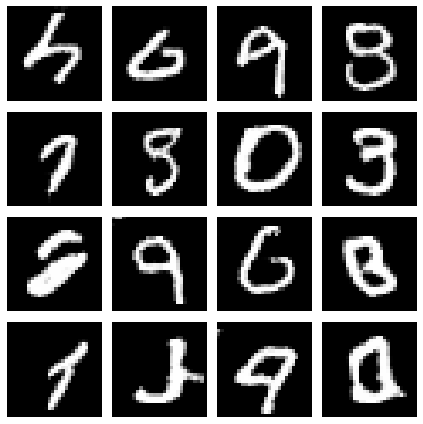


Start epoch 93
Epoch =  93
discriminator loss at epoch 93: 0.62
adversarial loss at epoch 93: 0.84


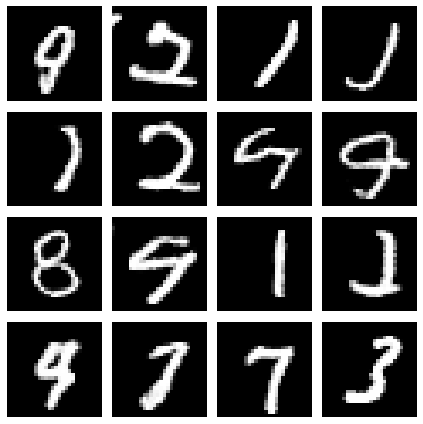


Start epoch 94
Epoch =  94
discriminator loss at epoch 94: 0.62
adversarial loss at epoch 94: 0.85


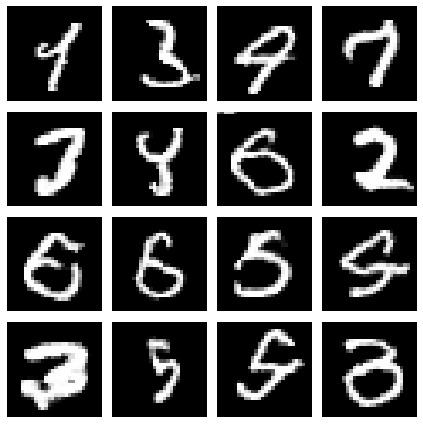


Start epoch 95
Epoch =  95
discriminator loss at epoch 95: 0.60
adversarial loss at epoch 95: 1.10


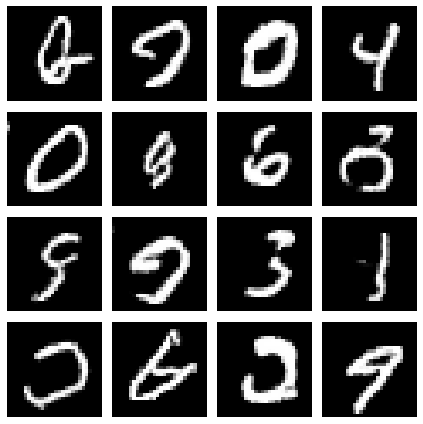


Start epoch 96
Epoch =  96
discriminator loss at epoch 96: 0.66
adversarial loss at epoch 96: 0.92


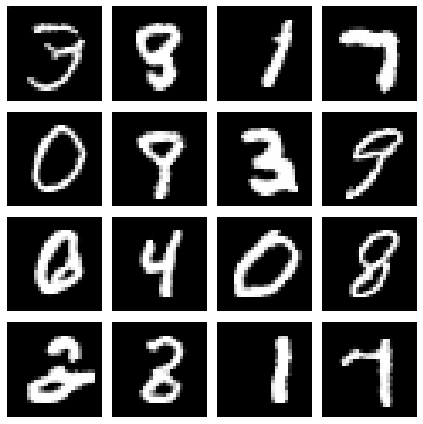


Start epoch 97
Epoch =  97
discriminator loss at epoch 97: 0.67
adversarial loss at epoch 97: 0.92


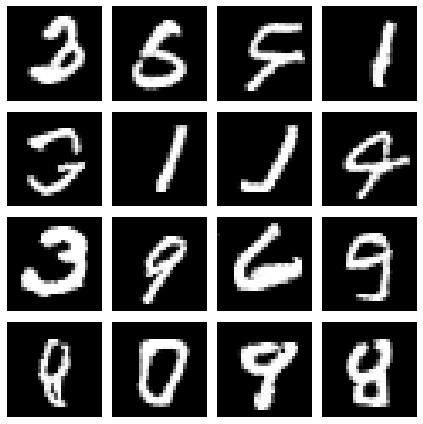


Start epoch 98
Epoch =  98
discriminator loss at epoch 98: 0.61
adversarial loss at epoch 98: 1.03


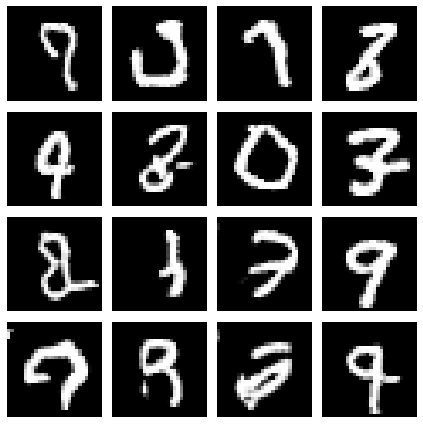


Start epoch 99
Epoch =  99
discriminator loss at epoch 99: 0.63
adversarial loss at epoch 99: 1.06


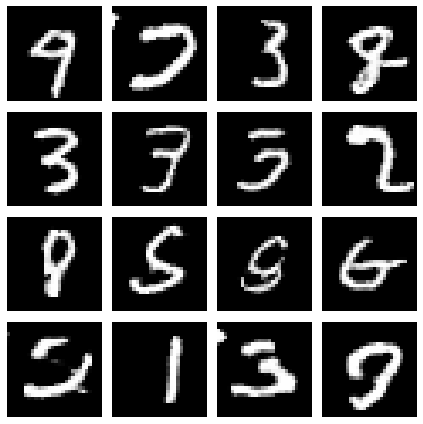

In [10]:
import os

# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
buffer_size=4096
dataset = dataset.shuffle(buffer_size=buffer_size).batch(batch_size)

epochs = 100  # In practice you need at least 20 epochs to generate nice digits.
save_dir = "./"

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

    # Logging.
    #if step % (buffer_size-1) == 0:
    # Print metrics
    print("Epoch = ",epoch)
    print("discriminator loss at epoch %d: %.2f" % (epoch, d_loss))
    print("adversarial loss at epoch %d: %.2f" % (epoch, g_loss))

    # Save one generated image
    #img = tf.keras.preprocessing.image.array_to_img(
    #    generated_images[0] * 255.0, scale=False
    #)
    #img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))

    # Plot generated images
    plt.figure(figsize=(6,6))
    for i in range(16):
               plt.subplot(4, 4, i+1)
               image = tf.keras.preprocessing.image.array_to_img(
                     generated_images[i] * 255.0, scale=False
               )
               #image = np.reshape(image, [self.img_rows, self.img_cols])
               plt.imshow(image, cmap='gray')
               plt.axis('off')
    plt.tight_layout()
    plt.show()



That's it! You'll get nice-looking fake MNIST digits.